In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalMaxPooling1D,GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # there are 9 files
k = 6 # number of classes (1-6)

In [3]:
def load_data():
    # returns
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))

    ts_filenames = [
        'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt', 'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
        'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt'
    ]

    ts_file_prefix = 'UCI-HAR/UCI-HAR-Dataset/train/'
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial-Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

    x = df.to_numpy()
    Xtrain[:, :, d] = x

    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt', header=None).to_numpy() -1
    Ytrain = Ytrain.flatten()

    ts_filenames = [
        'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_test.txt',
        'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
        'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt'
    ]

    ts_file_prefix = 'UCI-HAR/UCI-HAR-Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial-Signals/{fn}',
            header=None,
            delim_whitespace=True)

        x = df.to_numpy()
        Xtest[:, :, d] = x

        Ytest = pd.read_csv(
            f'{ts_file_prefix}y_test.txt', header=None).to_numpy() -1
        Ytest = Ytest.flatten()

        return Xtrain, Ytrain, Xtest, Ytest

In [4]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

In [5]:
len(Ytest)

2947

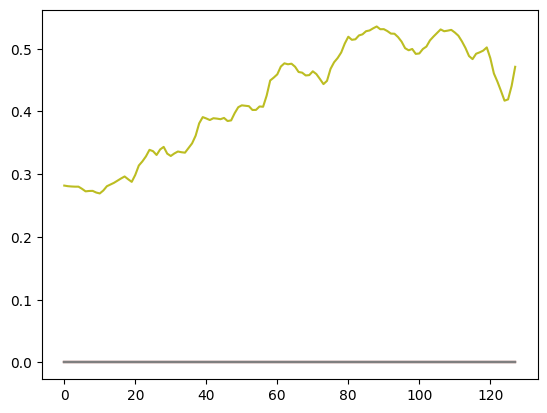

In [6]:
plt.plot(Xtrain[7000, :, :]);

In [7]:
Xtrain[7000, :, :]

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.2819087],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.2809712],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.2804833],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.4192851],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.4406889],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.4712126]])

In [8]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(k)(x)
model = Model(i, x)

2023-04-05 01:02:59.006698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 01:02:59.007174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 01:02:59.007313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-05 01:02:59.007402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-05 01:02:59.007508: W tensorflow/c

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           24704 

In [12]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True
)

In [14]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [15]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=15,
    callbacks=[check_point],
    validation_data=(Xtest, Ytest)
)

Epoch 1/15
230/230 [==============================] - 3s 8ms/step - loss: 1.0486 - accuracy: 0.5929 - val_loss: 1.6580 - val_accuracy: 0.3370
Epoch 2/15
230/230 [==============================] - 1s 6ms/step - loss: 0.6465 - accuracy: 0.7499 - val_loss: 1.6888 - val_accuracy: 0.3468
Epoch 3/15
230/230 [==============================] - 1s 6ms/step - loss: 0.5789 - accuracy: 0.7803 - val_loss: 1.6414 - val_accuracy: 0.2993
Epoch 4/15
230/230 [==============================] - 1s 6ms/step - loss: 0.5389 - accuracy: 0.7897 - val_loss: 1.6653 - val_accuracy: 0.3359
Epoch 5/15
230/230 [==============================] - 1s 6ms/step - loss: 0.5085 - accuracy: 0.8006 - val_loss: 1.9029 - val_accuracy: 0.2979
Epoch 6/15
230/230 [==============================] - 1s 6ms/step - loss: 0.4869 - accuracy: 0.8048 - val_loss: 1.7581 - val_accuracy: 0.2762
Epoch 7/15
230/230 [==============================] - 1s 6ms/step - loss: 0.4652 - accuracy: 0.8172 - val_loss: 1.9648 - val_accuracy: 0.2538
Epoch 

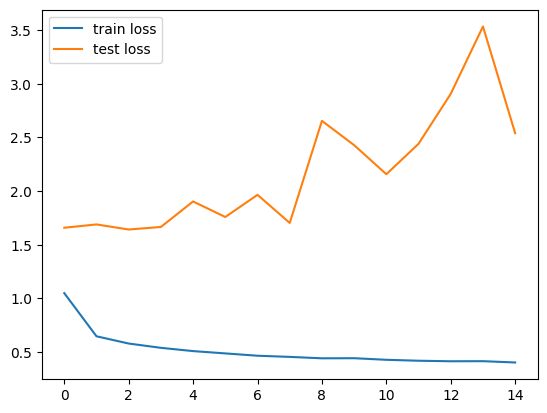

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [17]:
best_model = tf.keras.models.load_model('best_model.h5')

In [18]:
Ptest = best_model.predict(Xtest)

93/93 [==============================] - 0s 2ms/step


In [19]:
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.34679334916864607

In [22]:
from sklearn.preprocessing import StandardScaler

def load_features():
    df = pd.read_csv(
        'UCI-HAR/UCI-HAR-Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True
    )

    feat_train = df.to_numpy()

    df = pd.read_csv(
        'UCI-HAR/UCI-HAR-Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True
    )

    feat_test = df.to_numpy()

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.fit_transform(feat_test)

    return feat_train, feat_test

In [23]:
feat_train, feat_test = load_features()

In [24]:
feat_train

array([[ 0.20064157, -0.0636826 , -0.41962845, ..., -0.68721921,
         0.40794614, -0.00756789],
       [ 0.05594788,  0.03148567, -0.25390836, ..., -0.694138  ,
         0.40911698,  0.00787517],
       [ 0.07351535, -0.04341648, -0.07629468, ..., -0.702239  ,
         0.4102883 ,  0.02650234],
       ...,
       [-0.01566765,  0.0167814 ,  1.13222107, ..., -0.56584847,
         0.64059683,  0.34870928],
       [ 0.21586648, -0.02812252, -0.86770988, ..., -0.57766781,
         0.63147758,  0.29327564],
       [ 1.09620157,  0.12919873, -1.67268082, ..., -0.57392691,
         0.63274259,  0.33396081]])

In [25]:
D_feat = feat_train.shape[1]

In [26]:
D_feat

561

In [ ]:
#CNN
i = Input(shape=(T,D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat, ))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])


